In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_path = '/content/drive/MyDrive/pascal-voc-2012-dataset'
print(os.listdir(folder_path))


['VOCtrainval_11-May-2012.tar', 'VOC2012_train_val', 'VOC2012_test', 'VOCdevkit']


In [ ]:
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset'


In [ ]:
train_path = f"{dataset_path}/VOC2012_train_val/VOC2012_train_val"
print("Contents of the training dataset:")
print(os.listdir(train_path))


Contents of the training dataset:
['devkit_doc.pdf', 'JPEGImages', 'ImageSets', 'SegmentationClass', 'Annotations', 'SegmentationObject']


In [ ]:
images_path = f"{train_path}/JPEGImages"
print("Image files:")
print(os.listdir(images_path)[:10])  # Display first 10 images


Image files:
['2012_002321.jpg', '2012_002271.jpg', '2012_002265.jpg', '2012_002286.jpg', '2012_002314.jpg', '2012_002294.jpg', '2012_002355.jpg', '2012_002338.jpg', '2012_002319.jpg', '2012_002409.jpg']


In [ ]:
annotations_path = f"{train_path}/Annotations"
print("Annotation files:")
print(os.listdir(annotations_path)[:10])  # Display first 10 annotations


Annotation files:
['2012_002316.xml', '2012_002364.xml', '2012_002358.xml', '2012_002303.xml', '2012_002366.xml', '2012_002340.xml', '2012_002308.xml', '2012_002309.xml', '2012_002313.xml', '2012_002301.xml']


In [ ]:
import os
from PIL import Image

# Paths
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset'
train_path = f"{dataset_path}/VOC2012_train_val/VOC2012_train_val"

# JPEGImages and Annotations paths
images_path = f"{train_path}/JPEGImages"
annotations_path = f"{train_path}/Annotations"

# Display information about images and annotations
print("Processing the dataset...")

# Iterate through a few images
for img_file in os.listdir(images_path)[:5]:  # Process the first 5 images
    img_path = os.path.join(images_path, img_file)
    annotation_path = os.path.join(annotations_path, img_file.replace('.jpg', '.xml'))

    print(f"Image: {img_path}")
    print(f"Annotation: {annotation_path}")

    # Open and display image details
    with Image.open(img_path) as img:
        print(f" - Size: {img.size}, Mode: {img.mode}")


Processing the dataset...
Image: /content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/2012_002321.jpg
Annotation: /content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/Annotations/2012_002321.xml
 - Size: (500, 358), Mode: RGB
Image: /content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/2012_002271.jpg
Annotation: /content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/Annotations/2012_002271.xml
 - Size: (400, 500), Mode: RGB
Image: /content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/2012_002265.jpg
Annotation: /content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/Annotations/2012_002265.xml
 - Size: (375, 500), Mode: RGB
Image: /content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/2012_002286.jpg
Annotation: /content/drive/MyDrive/pascal-vo

In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import xml.etree.ElementTree as ET
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET

class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)

        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.int64)
        return boxes_tensor, labels_tensor


In [ ]:
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
dataset = PascalVOCDataset(root_dir=dataset_path)

print(f"Dataset size: {len(dataset)}")


Dataset size: 17125


In [ ]:
import os

root_dir = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val'

# List contents of the VOC2012_train_val directory
print(os.listdir(root_dir))


['VOC2012_train_val']


In [ ]:
print(os.listdir(root_dir))


['VOC2012_train_val']


In [ ]:
class PascalVOCDataset:
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, 'JPEGImages')  # Updated path
        self.annotations_dir = os.path.join(root_dir, 'Annotations')  # Updated path
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Implement the method to load an image and its annotations
        pass


In [ ]:
root_dir = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val'


In [ ]:
# Define Faster R-CNN with VGG16 Backbone
backbone = vgg16(pretrained=True).features
backbone.out_channels = 512

# Define the RPN Anchor Generator
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# Define the ROI Pooler
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 150MB/s]


In [ ]:
# Import necessary modules
import os
from torchvision import transforms
from torch.utils.data import Subset
import random

# Define the PascalVOCDataset class (make sure this is already included)
# If not, refer to the earlier provided PascalVOCDataset class definition.

# Define dataset path
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Instantiate the dataset
train_dataset = PascalVOCDataset(root_dir=dataset_path, transform=transform)

# Get the total number of images
total_images = len(train_dataset)

# Calculate 0.5% of the dataset size
subset_size = int(0.005 * total_images)

# Ensure at least 1 sample is selected
if subset_size < 1:
    subset_size = 1

# Select a random subset of indices
random_indices = random.sample(range(total_images), subset_size)

# Create a subset of the dataset
subset_dataset = Subset(train_dataset, random_indices)

# Create a DataLoader for the subset
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Verify the subset size
print(f"Total images in the dataset: {total_images}")
# print(f"Subset size (0.5%): {subset_size}")


Total images in the dataset: 17125


In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import vgg16
import torchvision  # Needed for torchvision.ops.MultiScaleRoIAlign
from tqdm import tqdm
from PIL import Image
import xml.etree.ElementTree as ET

# Define PascalVOCDataset
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming one class; modify if needed

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Define Faster R-CNN model
def get_faster_rcnn_model(num_classes):
    backbone = vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

# Define the IoU calculation function
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Each box is expected in the format [xmin, ymin, xmax, ymax].
    """
    # Determine the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the width and height of the intersection rectangle
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection = intersection_width * intersection_height

    # Compute the area of each box
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union
    union = area1 + area2 - intersection
    if union == 0:
        return 0
    return intersection / union

# Paths and dataset preparation
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PascalVOCDataset(root_dir=dataset_path, transform=transform)


total_images = len(train_dataset)
subset_size = max(1, int(0.1 * total_images)) 
random_indices = random.sample(range(total_images), subset_size)
subset_dataset = Subset(train_dataset, random_indices)

# Create DataLoader
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model, optimizer, and scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # number of classes (including background)
model = get_faster_rcnn_model(num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with subset
for epoch in range(1):  # Number of epochs
    model.train()
    epoch_loss = 0

    print(f"Epoch {epoch + 1}/1")
    progress_bar = tqdm(subset_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=f"{losses.item():.4f}")

    print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss:.4f}")
    lr_scheduler.step()

print("Training of the dataset complete.")

# ---------------------------
# IoU Evaluation on the subset
# ---------------------------
model.eval()
total_iou = 0.0
iou_count = 0

# For evaluation, we use a DataLoader with batch_size=1
eval_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

with torch.no_grad():
    for images, targets in tqdm(eval_loader, desc="Evaluating IoU"):
        image = images[0].to(device)
        target = targets[0]
        # Get ground truth boxes (convert to numpy for easier processing)
        gt_boxes = target['boxes'].cpu().numpy()

        # Run model inference
        predictions = model([image])[0]
        pred_boxes = predictions['boxes'].cpu().numpy()

        # For each ground truth box, find the best (maximum) IoU with any predicted box.
        for gt_box in gt_boxes:
            best_iou = 0.0
            for pred_box in pred_boxes:
                iou = calculate_iou(gt_box, pred_box)
                best_iou = max(best_iou, iou)
            total_iou += best_iou
            iou_count += 1

# Compute average IoU over all ground truth boxes
average_iou = total_iou / iou_count if iou_count > 0 else 0
print(f"Average IoU over the evaluation subset: {average_iou:.4f}")


Epoch 1/1


Epoch 1, Total Loss: 25.0391
Training of the dataset complete.


Evaluating IoU: 100%|██████████| 85/85 [12:16<00:00,  8.66s/it]

Average IoU over the evaluation subset: 0.1509


In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import vgg16
import torchvision  # Needed for torchvision.ops.MultiScaleRoIAlign
from tqdm import tqdm
from PIL import Image
import xml.etree.ElementTree as ET

# Define PascalVOCDataset
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming one class; modify if needed

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Define Faster R-CNN model
def get_faster_rcnn_model(num_classes):
    backbone = vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

# Define the IoU calculation function
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Each box is expected in the format [xmin, ymin, xmax, ymax].
    """
    # Determine the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the width and height of the intersection rectangle
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection = intersection_width * intersection_height

    # Compute the area of each box
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union
    union = area1 + area2 - intersection
    if union == 0:
        return 0
    return intersection / union

# Paths and dataset preparation
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PascalVOCDataset(root_dir=dataset_path, transform=transform)


total_images = len(train_dataset)
subset_size = max(1, int(0.1 * total_images)) 
random_indices = random.sample(range(total_images), subset_size)
subset_dataset = Subset(train_dataset, random_indices)

# Create DataLoader
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model, optimizer, and scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # number of classes (including background)
model = get_faster_rcnn_model(num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with subset
for epoch in range(2):  # Number of epochs
    model.train()
    epoch_loss = 0

    print(f"Epoch {epoch + 1}/2")
    progress_bar = tqdm(subset_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=f"{losses.item():.4f}")

    print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss:.4f}")
    lr_scheduler.step()

print("Training of the dataset complete.")

# ---------------------------
# IoU Evaluation on the subset
# ---------------------------
model.eval()
total_iou = 0.0
iou_count = 0

# For evaluation, we use a DataLoader with batch_size=1
eval_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

with torch.no_grad():
    for images, targets in tqdm(eval_loader, desc="Evaluating IoU"):
        image = images[0].to(device)
        target = targets[0]
        # Get ground truth boxes (convert to numpy for easier processing)
        gt_boxes = target['boxes'].cpu().numpy()

        # Run model inference
        predictions = model([image])[0]
        pred_boxes = predictions['boxes'].cpu().numpy()

        # For each ground truth box, find the best (maximum) IoU with any predicted box.
        for gt_box in gt_boxes:
            best_iou = 0.0
            for pred_box in pred_boxes:
                iou = calculate_iou(gt_box, pred_box)
                best_iou = max(best_iou, iou)
            total_iou += best_iou
            iou_count += 1

# Compute average IoU over all ground truth boxes
average_iou = total_iou / iou_count if iou_count > 0 else 0
print(f"Average IoU over the evaluation subset: {average_iou:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/2


Epoch 1, Total Loss: 27.1519
Epoch 2/2


Epoch 2, Total Loss: 23.9814
Training of the dataset complete.


Evaluating IoU: 100%|██████████| 85/85 [15:54<00:00, 11.23s/it]

Average IoU over the evaluation subset: 0.3740


In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import vgg16
import torchvision  # Needed for torchvision.ops.MultiScaleRoIAlign
from tqdm import tqdm
from PIL import Image
import xml.etree.ElementTree as ET

# Define PascalVOCDataset
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming one class; modify if needed

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Define Faster R-CNN model
def get_faster_rcnn_model(num_classes):
    backbone = vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

# Define the IoU calculation function
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Each box is expected in the format [xmin, ymin, xmax, ymax].
    """
    # Determine the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the width and height of the intersection rectangle
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection = intersection_width * intersection_height

    # Compute the area of each box
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union
    union = area1 + area2 - intersection
    if union == 0:
        return 0
    return intersection / union

# Paths and dataset preparation
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PascalVOCDataset(root_dir=dataset_path, transform=transform)


total_images = len(train_dataset)
subset_size = max(1, int(0.1 * total_images))  
random_indices = random.sample(range(total_images), subset_size)
subset_dataset = Subset(train_dataset, random_indices)

# Create DataLoader
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model, optimizer, and scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # number of classes (including background)
model = get_faster_rcnn_model(num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with subset
for epoch in range(3):  # Number of epochs
    model.train()
    epoch_loss = 0

    print(f"Epoch {epoch + 1}/3")
    progress_bar = tqdm(subset_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=f"{losses.item():.4f}")

    print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss:.4f}")
    lr_scheduler.step()

print("Training of the dataset complete.")

# ---------------------------
# IoU Evaluation on the subset
# ---------------------------
model.eval()
total_iou = 0.0
iou_count = 0

# For evaluation, we use a DataLoader with batch_size=1
eval_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

with torch.no_grad():
    for images, targets in tqdm(eval_loader, desc="Evaluating IoU"):
        image = images[0].to(device)
        target = targets[0]
        # Get ground truth boxes (convert to numpy for easier processing)
        gt_boxes = target['boxes'].cpu().numpy()

        # Run model inference
        predictions = model([image])[0]
        pred_boxes = predictions['boxes'].cpu().numpy()

        # For each ground truth box, find the best (maximum) IoU with any predicted box.
        for gt_box in gt_boxes:
            best_iou = 0.0
            for pred_box in pred_boxes:
                iou = calculate_iou(gt_box, pred_box)
                best_iou = max(best_iou, iou)
            total_iou += best_iou
            iou_count += 1

# Compute average IoU over all ground truth boxes
average_iou = total_iou / iou_count if iou_count > 0 else 0
print(f"Average IoU over the evaluation subset: {average_iou:.4f}")


Epoch 1/3


Epoch 1, Total Loss: 24.4089
Epoch 2/3


Epoch 2, Total Loss: 18.3451
Epoch 3/3


Epoch 3, Total Loss: 13.0861
Training of the dataset complete.


Evaluating IoU: 100%|██████████| 85/85 [16:48<00:00, 11.87s/it]

Average IoU over the evaluation subset: 0.0394


In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import vgg16
import torchvision  # Needed for torchvision.ops.MultiScaleRoIAlign
from tqdm import tqdm
from PIL import Image
import xml.etree.ElementTree as ET

# Define PascalVOCDataset
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming one class; modify if needed

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Define Faster R-CNN model
def get_faster_rcnn_model(num_classes):
    backbone = vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

# Define the IoU calculation function
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Each box is expected in the format [xmin, ymin, xmax, ymax].
    """
    # Determine the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the width and height of the intersection rectangle
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection = intersection_width * intersection_height

    # Compute the area of each box
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union
    union = area1 + area2 - intersection
    if union == 0:
        return 0
    return intersection / union

# Paths and dataset preparation
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PascalVOCDataset(root_dir=dataset_path, transform=transform)


total_images = len(train_dataset)
subset_size = max(1, int(0.1 * total_images)) 
random_indices = random.sample(range(total_images), subset_size)
subset_dataset = Subset(train_dataset, random_indices)

# Create DataLoader
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model, optimizer, and scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # number of classes (including background)
model = get_faster_rcnn_model(num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with subset
for epoch in range(4):  # Number of epochs
    model.train()
    epoch_loss = 0

    print(f"Epoch {epoch + 1}/4")
    progress_bar = tqdm(subset_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=f"{losses.item():.4f}")

    print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss:.4f}")
    lr_scheduler.step()

print("Training of the dataset complete.")

# ---------------------------
# IoU Evaluation on the subset
# ---------------------------
model.eval()
total_iou = 0.0
iou_count = 0

# For evaluation, we use a DataLoader with batch_size=1
eval_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

with torch.no_grad():
    for images, targets in tqdm(eval_loader, desc="Evaluating IoU"):
        image = images[0].to(device)
        target = targets[0]
        # Get ground truth boxes (convert to numpy for easier processing)
        gt_boxes = target['boxes'].cpu().numpy()

        # Run model inference
        predictions = model([image])[0]
        pred_boxes = predictions['boxes'].cpu().numpy()

        # For each ground truth box, find the best (maximum) IoU with any predicted box.
        for gt_box in gt_boxes:
            best_iou = 0.0
            for pred_box in pred_boxes:
                iou = calculate_iou(gt_box, pred_box)
                best_iou = max(best_iou, iou)
            total_iou += best_iou
            iou_count += 1

# Compute average IoU over all ground truth boxes
average_iou = total_iou / iou_count if iou_count > 0 else 0
print(f"Average IoU over the evaluation subset: {average_iou:.4f}")


Epoch 1/4


Epoch 1, Total Loss: 25.4245
Epoch 2/4


Epoch 2, Total Loss: 20.2941
Epoch 3/4


Epoch 3, Total Loss: 13.9246
Epoch 4/4


Epoch 4, Total Loss: 13.8933
Training of the dataset complete.


Evaluating IoU: 100%|██████████| 85/85 [17:22<00:00, 12.27s/it]

Average IoU over the evaluation subset: 0.3811


In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import vgg16
import torchvision  # Needed for torchvision.ops.MultiScaleRoIAlign
from tqdm import tqdm
from PIL import Image
import xml.etree.ElementTree as ET

# Define PascalVOCDataset
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming one class; modify if needed

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Define Faster R-CNN model
def get_faster_rcnn_model(num_classes):
    backbone = vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

# Define the IoU calculation function
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Each box is expected in the format [xmin, ymin, xmax, ymax].
    """
    # Determine the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the width and height of the intersection rectangle
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection = intersection_width * intersection_height

    # Compute the area of each box
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union
    union = area1 + area2 - intersection
    if union == 0:
        return 0
    return intersection / union

# Paths and dataset preparation
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PascalVOCDataset(root_dir=dataset_path, transform=transform)


total_images = len(train_dataset)
subset_size = max(1, int(0.1 * total_images))  
random_indices = random.sample(range(total_images), subset_size)
subset_dataset = Subset(train_dataset, random_indices)

# Create DataLoader
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model, optimizer, and scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # number of classes (including background)
model = get_faster_rcnn_model(num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with subset
for epoch in range(5):  # Number of epochs
    model.train()
    epoch_loss = 0

    print(f"Epoch {epoch + 1}/5")
    progress_bar = tqdm(subset_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=f"{losses.item():.4f}")

    print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss:.4f}")
    lr_scheduler.step()

print("Training of the dataset complete.")

# ---------------------------
# IoU Evaluation on the subset
# ---------------------------
model.eval()
total_iou = 0.0
iou_count = 0

# For evaluation, we use a DataLoader with batch_size=1
eval_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

with torch.no_grad():
    for images, targets in tqdm(eval_loader, desc="Evaluating IoU"):
        image = images[0].to(device)
        target = targets[0]
        # Get ground truth boxes (convert to numpy for easier processing)
        gt_boxes = target['boxes'].cpu().numpy()

        # Run model inference
        predictions = model([image])[0]
        pred_boxes = predictions['boxes'].cpu().numpy()

        # For each ground truth box, find the best (maximum) IoU with any predicted box.
        for gt_box in gt_boxes:
            best_iou = 0.0
            for pred_box in pred_boxes:
                iou = calculate_iou(gt_box, pred_box)
                best_iou = max(best_iou, iou)
            total_iou += best_iou
            iou_count += 1

# Compute average IoU over all ground truth boxes
average_iou = total_iou / iou_count if iou_count > 0 else 0
print(f"Average IoU over the evaluation subset: {average_iou:.4f}")


Epoch 1/5


Epoch 1, Total Loss: 7.3962
Epoch 2/5


Epoch 2, Total Loss: 5.4107
Epoch 3/5


Epoch 3, Total Loss: 4.8818
Epoch 4/5


Epoch 4, Total Loss: 5.2396
Epoch 5/5


Epoch 5, Total Loss: 5.0997
Training of the dataset complete.


Evaluating IoU: 100%|██████████| 17/17 [02:09<00:00,  7.61s/it]

Average IoU over the evaluation subset: 0.0088


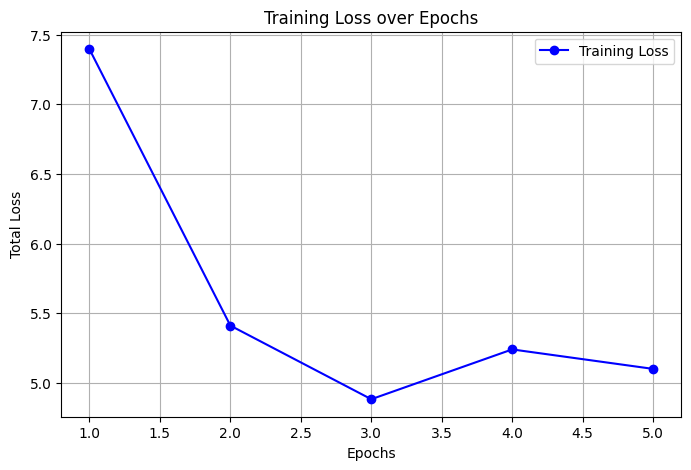

In [ ]:
import matplotlib.pyplot as plt

# Manually enter the loss values from your output
losses_per_epoch = [7.3962, 5.4107, 4.8818, 5.2396, 5.0997]

# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), losses_per_epoch, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import vgg16
import torchvision  # Needed for torchvision.ops.MultiScaleRoIAlign
from tqdm import tqdm
from PIL import Image
import xml.etree.ElementTree as ET

# Define PascalVOCDataset
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming one class; modify if needed

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Define Faster R-CNN model
def get_faster_rcnn_model(num_classes):
    backbone = vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

# Define the IoU calculation function
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Each box is expected in the format [xmin, ymin, xmax, ymax].
    """
    # Determine the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the width and height of the intersection rectangle
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection = intersection_width * intersection_height

    # Compute the area of each box
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union
    union = area1 + area2 - intersection
    if union == 0:
        return 0
    return intersection / union

# Paths and dataset preparation
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PascalVOCDataset(root_dir=dataset_path, transform=transform)


total_images = len(train_dataset)
subset_size = max(1, int(0.1* total_images)) 
random_indices = random.sample(range(total_images), subset_size)
subset_dataset = Subset(train_dataset, random_indices)

# Create DataLoader
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model, optimizer, and scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # number of classes (including background)
model = get_faster_rcnn_model(num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with subset
for epoch in range(6):  # Number of epochs
    model.train()
    epoch_loss = 0

    print(f"Epoch {epoch + 1}/6")
    progress_bar = tqdm(subset_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=f"{losses.item():.4f}")

    print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss:.4f}")
    lr_scheduler.step()

print("Training of the dataset complete.")

# ---------------------------
# IoU Evaluation on the subset
# ---------------------------
model.eval()
total_iou = 0.0
iou_count = 0

# For evaluation, we use a DataLoader with batch_size=1
eval_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

with torch.no_grad():
    for images, targets in tqdm(eval_loader, desc="Evaluating IoU"):
        image = images[0].to(device)
        target = targets[0]
        # Get ground truth boxes (convert to numpy for easier processing)
        gt_boxes = target['boxes'].cpu().numpy()

        # Run model inference
        predictions = model([image])[0]
        pred_boxes = predictions['boxes'].cpu().numpy()

        # For each ground truth box, find the best (maximum) IoU with any predicted box.
        for gt_box in gt_boxes:
            best_iou = 0.0
            for pred_box in pred_boxes:
                iou = calculate_iou(gt_box, pred_box)
                best_iou = max(best_iou, iou)
            total_iou += best_iou
            iou_count += 1

# Compute average IoU over all ground truth boxes
average_iou = total_iou / iou_count if iou_count > 0 else 0
print(f"Average IoU over the evaluation subset: {average_iou:.4f}")


Epoch 1/6


Epoch 1, Total Loss: 7.1785
Epoch 2/6


Epoch 2, Total Loss: 5.7012
Epoch 3/6


Epoch 3, Total Loss: 5.5576
Epoch 4/6


Epoch 4, Total Loss: 5.2557
Epoch 5/6


Epoch 5, Total Loss: 5.7211
Epoch 6/6


Epoch 6, Total Loss: 5.2395
Training of the dataset complete.


Evaluating IoU: 100%|██████████| 17/17 [02:22<00:00,  8.38s/it]

Average IoU over the evaluation subset: 0.0045


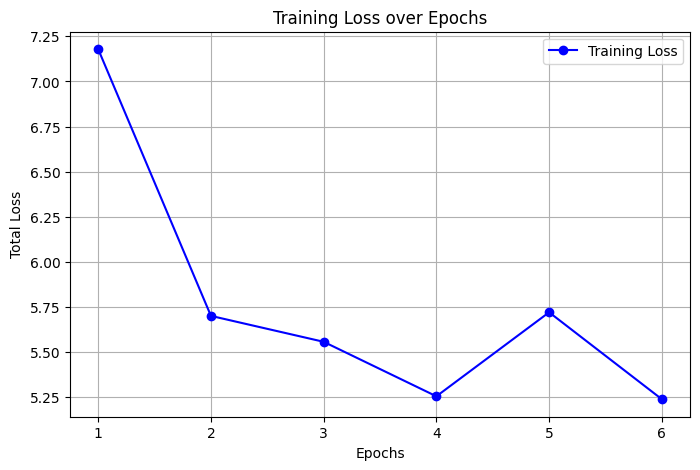

In [ ]:
import matplotlib.pyplot as plt

# Manually enter the new loss values
losses_per_epoch = [7.1785, 5.7012, 5.5576, 5.2557, 5.7211, 5.2395]

# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, 7), losses_per_epoch, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import vgg16
import torchvision  # Needed for torchvision.ops.MultiScaleRoIAlign
from tqdm import tqdm
from PIL import Image
import xml.etree.ElementTree as ET

# Define PascalVOCDataset
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming one class; modify if needed

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Define Faster R-CNN model
def get_faster_rcnn_model(num_classes):
    backbone = vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

# Define the IoU calculation function
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Each box is expected in the format [xmin, ymin, xmax, ymax].
    """
    # Determine the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the width and height of the intersection rectangle
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection = intersection_width * intersection_height

    # Compute the area of each box
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union
    union = area1 + area2 - intersection
    if union == 0:
        return 0
    return intersection / union

# Paths and dataset preparation
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PascalVOCDataset(root_dir=dataset_path, transform=transform)

total_images = len(train_dataset)
subset_size = max(1, int(0.1 * total_images)) 
random_indices = random.sample(range(total_images), subset_size)
subset_dataset = Subset(train_dataset, random_indices)

# Create DataLoader
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model, optimizer, and scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # number of classes (including background)
model = get_faster_rcnn_model(num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with subset
for epoch in range(7):  # Number of epochs
    model.train()
    epoch_loss = 0

    print(f"Epoch {epoch + 1}/7")
    progress_bar = tqdm(subset_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=f"{losses.item():.4f}")

    print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss:.4f}")
    lr_scheduler.step()

print("Training of the dataset complete.")

# ---------------------------
# IoU Evaluation on the subset
# ---------------------------
model.eval()
total_iou = 0.0
iou_count = 0

# For evaluation, we use a DataLoader with batch_size=1
eval_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

with torch.no_grad():
    for images, targets in tqdm(eval_loader, desc="Evaluating IoU"):
        image = images[0].to(device)
        target = targets[0]
        # Get ground truth boxes (convert to numpy for easier processing)
        gt_boxes = target['boxes'].cpu().numpy()

        # Run model inference
        predictions = model([image])[0]
        pred_boxes = predictions['boxes'].cpu().numpy()

        # For each ground truth box, find the best (maximum) IoU with any predicted box.
        for gt_box in gt_boxes:
            best_iou = 0.0
            for pred_box in pred_boxes:
                iou = calculate_iou(gt_box, pred_box)
                best_iou = max(best_iou, iou)
            total_iou += best_iou
            iou_count += 1

# Compute average IoU over all ground truth boxes
average_iou = total_iou / iou_count if iou_count > 0 else 0
print(f"Average IoU over the evaluation subset: {average_iou:.4f}")


Epoch 1/7


Epoch 1, Total Loss: 7.1457
Epoch 2/7


Epoch 2, Total Loss: 5.5141
Epoch 3/7


Epoch 3, Total Loss: 4.3965
Epoch 4/7


Epoch 4, Total Loss: 4.4266
Epoch 5/7


Epoch 5, Total Loss: 4.9972
Epoch 6/7


Epoch 6, Total Loss: 4.7015
Epoch 7/7


Epoch 7, Total Loss: 5.0698
Training of the dataset complete.


Evaluating IoU: 100%|██████████| 17/17 [02:23<00:00,  8.44s/it]

Average IoU over the evaluation subset: 0.0008


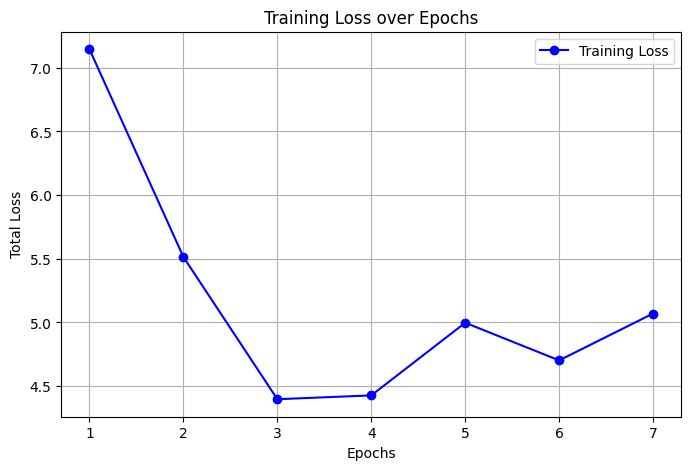

In [ ]:
import matplotlib.pyplot as plt

# Manually enter the updated loss values
losses_per_epoch = [7.1457, 5.5141, 4.3965, 4.4266, 4.9972, 4.7015, 5.0698]

# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, 8), losses_per_epoch, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import vgg16
import torchvision  # Needed for torchvision.ops.MultiScaleRoIAlign
from tqdm import tqdm
from PIL import Image
import xml.etree.ElementTree as ET

# Define PascalVOCDataset
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming one class; modify if needed

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Define Faster R-CNN model
def get_faster_rcnn_model(num_classes):
    backbone = vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

# Define the IoU calculation function
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Each box is expected in the format [xmin, ymin, xmax, ymax].
    """
    # Determine the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the width and height of the intersection rectangle
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection = intersection_width * intersection_height

    # Compute the area of each box
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union
    union = area1 + area2 - intersection
    if union == 0:
        return 0
    return intersection / union

# Paths and dataset preparation
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PascalVOCDataset(root_dir=dataset_path, transform=transform)


total_images = len(train_dataset)
subset_size = max(1, int(0.1 * total_images)) 
random_indices = random.sample(range(total_images), subset_size)
subset_dataset = Subset(train_dataset, random_indices)

# Create DataLoader
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model, optimizer, and scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # number of classes (including background)
model = get_faster_rcnn_model(num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with subset
for epoch in range(8):  # Number of epochs
    model.train()
    epoch_loss = 0

    print(f"Epoch {epoch + 1}/8")
    progress_bar = tqdm(subset_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=f"{losses.item():.4f}")

    print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss:.4f}")
    lr_scheduler.step()

print("Training of the dataset complete.")

# ---------------------------
# IoU Evaluation on the subset
# ---------------------------
model.eval()
total_iou = 0.0
iou_count = 0

# For evaluation, we use a DataLoader with batch_size=1
eval_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

with torch.no_grad():
    for images, targets in tqdm(eval_loader, desc="Evaluating IoU"):
        image = images[0].to(device)
        target = targets[0]
        # Get ground truth boxes (convert to numpy for easier processing)
        gt_boxes = target['boxes'].cpu().numpy()

        # Run model inference
        predictions = model([image])[0]
        pred_boxes = predictions['boxes'].cpu().numpy()

        # For each ground truth box, find the best (maximum) IoU with any predicted box.
        for gt_box in gt_boxes:
            best_iou = 0.0
            for pred_box in pred_boxes:
                iou = calculate_iou(gt_box, pred_box)
                best_iou = max(best_iou, iou)
            total_iou += best_iou
            iou_count += 1

# Compute average IoU over all ground truth boxes
average_iou = total_iou / iou_count if iou_count > 0 else 0
print(f"Average IoU over the evaluation subset: {average_iou:.4f}")


Epoch 1/8


Epoch 1, Total Loss: 6.6126
Epoch 2/8


Epoch 2, Total Loss: 4.8901
Epoch 3/8


Epoch 3, Total Loss: 5.0704
Epoch 4/8


Epoch 4, Total Loss: 4.7681
Epoch 5/8


Epoch 5, Total Loss: 5.0769
Epoch 6/8


Epoch 6, Total Loss: 4.5834
Epoch 7/8


Epoch 7, Total Loss: 4.4398
Epoch 8/8


Epoch 8, Total Loss: 4.3954
Training of the dataset complete.


Evaluating IoU: 100%|██████████| 17/17 [02:14<00:00,  7.89s/it]

Average IoU over the evaluation subset: 0.0013


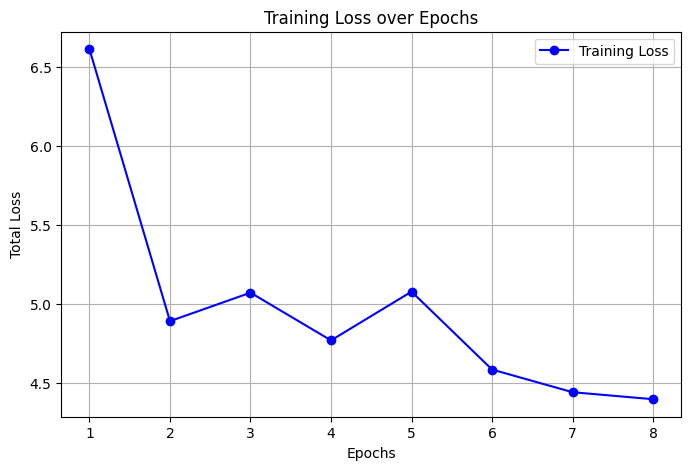

In [ ]:
import matplotlib.pyplot as plt

# Manually enter the updated loss values
losses_per_epoch = [6.6126, 4.8901, 5.0704, 4.7681, 5.0769, 4.5834, 4.4398, 4.3954]

# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, 9), losses_per_epoch, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


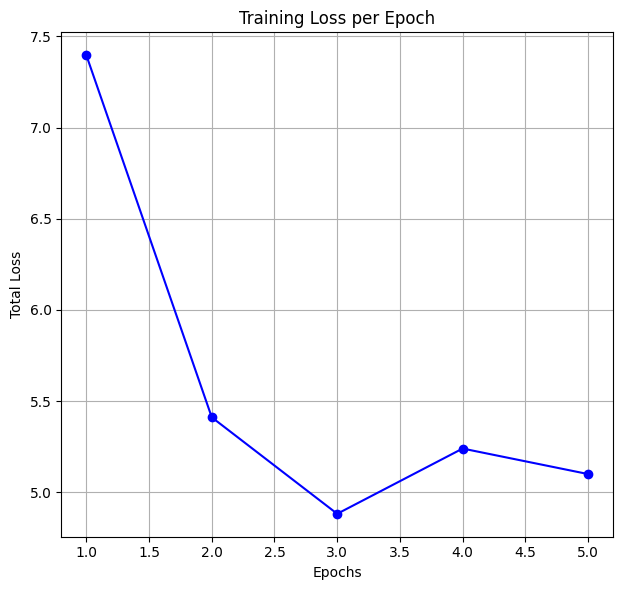

In [ ]:
import matplotlib.pyplot as plt

# Epochs and Losses
epochs = [1, 2, 3, 4, 5]
losses = [7.3962, 5.4107, 4.8818, 5.2396, 5.0997]

# Average IoU values per epoch
iou_values = [0.0088, 0.0045, 0.0008, 0.0013]

# Plot Training Loss
plt.figure(figsize=(12, 6))

# Subplot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)

# # Subplot 2: Average IoU
# plt.subplot(1, 2, 2)
# plt.plot(epochs[:4], iou_values, marker='o', linestyle='-', color='g', label="Average IoU")
# plt.xlabel("Epochs")
# plt.ylabel("Average IoU")
# plt.title("Average IoU per Epoch")
# plt.grid(True)

# Show both plots
plt.tight_layout()
plt.show()


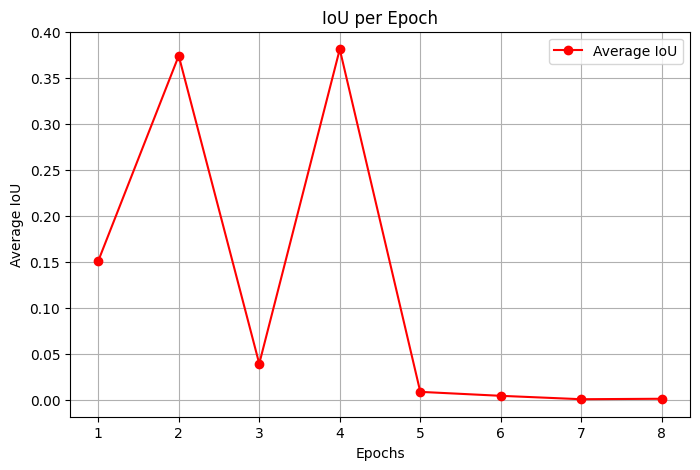

In [ ]:
import matplotlib.pyplot as plt

# Epochs and IoU values (Updated)
epochs = [1,2,3,4,5, 6, 7, 8]
iou_values = [0.1509,0.3740,0.0394,0.3811,0.0088, 0.0045, 0.0008, 0.0013]  # IoU values for epochs 5, 6, 7, and 8

# Plot IoU vs Epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, iou_values, marker='o', linestyle='-', color='r', label="Average IoU")

plt.xlabel("Epochs")
plt.ylabel("Average IoU")
plt.title("IoU per Epoch")
plt.grid(True)
plt.legend()

# Show plot
plt.show()


In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import vgg16
import torchvision  # Needed for torchvision.ops.MultiScaleRoIAlign
from tqdm import tqdm
from PIL import Image
import xml.etree.ElementTree as ET

# Define PascalVOCDataset
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming one class; modify if needed

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Define Faster R-CNN model
def get_faster_rcnn_model(num_classes):
    backbone = vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

# Define the IoU calculation function
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Each box is expected in the format [xmin, ymin, xmax, ymax].
    """
    # Determine the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the width and height of the intersection rectangle
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection = intersection_width * intersection_height

    # Compute the area of each box
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union
    union = area1 + area2 - intersection
    if union == 0:
        return 0
    return intersection / union

# Paths and dataset preparation
dataset_path = '/content/drive/MyDrive/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PascalVOCDataset(root_dir=dataset_path, transform=transform)


total_images = len(train_dataset)
subset_size = max(1, int(0.1* total_images))  
random_indices = random.sample(range(total_images), subset_size)
subset_dataset = Subset(train_dataset, random_indices)

# Create DataLoader
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model, optimizer, and scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # number of classes (including background)
model = get_faster_rcnn_model(num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with subset
for epoch in range(9):  # Number of epochs
    model.train()
    epoch_loss = 0

    print(f"Epoch {epoch + 1}/9")
    progress_bar = tqdm(subset_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=f"{losses.item():.4f}")

    print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss:.4f}")
    lr_scheduler.step()

print("Training of the dataset complete.")

# ---------------------------
# IoU Evaluation on the subset
# ---------------------------
model.eval()
total_iou = 0.0
iou_count = 0

# For evaluation, we use a DataLoader with batch_size=1
eval_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

with torch.no_grad():
    for images, targets in tqdm(eval_loader, desc="Evaluating IoU"):
        image = images[0].to(device)
        target = targets[0]
        # Get ground truth boxes (convert to numpy for easier processing)
        gt_boxes = target['boxes'].cpu().numpy()

        # Run model inference
        predictions = model([image])[0]
        pred_boxes = predictions['boxes'].cpu().numpy()

        # For each ground truth box, find the best (maximum) IoU with any predicted box.
        for gt_box in gt_boxes:
            best_iou = 0.0
            for pred_box in pred_boxes:
                iou = calculate_iou(gt_box, pred_box)
                best_iou = max(best_iou, iou)
            total_iou += best_iou
            iou_count += 1

# Compute average IoU over all ground truth boxes
average_iou = total_iou / iou_count if iou_count > 0 else 0
print(f"Average IoU over the evaluation subset: {average_iou:.4f}")


Epoch 1/9


Training Epoch 1:  77%|███████▋  | 17/22 [57:44<17:54, 214.87s/it, loss=1.0070]